<a href="https://colab.research.google.com/github/myselfdk03/fPINNs/blob/main/time_fractional_burger_huxley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss: 0.05931229144334793, BC Loss Weight: 1.0, Residual Weight: 0.0
Epoch 500, Loss: 0.055984336882829666, BC Loss Weight: 0.9, Residual Weight: 0.1
Epoch 1000, Loss: 0.0005461190594360232, BC Loss Weight: 0.8, Residual Weight: 0.2
Epoch 1500, Loss: 0.00025302686844952404, BC Loss Weight: 0.7, Residual Weight: 0.3
Epoch 2000, Loss: 0.00012799508112948388, BC Loss Weight: 0.6, Residual Weight: 0.4
Epoch 2500, Loss: 7.708623888902366e-05, BC Loss Weight: 0.5, Residual Weight: 0.5
Epoch 3000, Loss: 5.630266241496429e-05, BC Loss Weight: 0.4, Residual Weight: 0.6
Epoch 3500, Loss: 4.272974547347985e-05, BC Loss Weight: 0.30000000000000004, Residual Weight: 0.7
Epoch 4000, Loss: 3.5472447052598e-05, BC Loss Weight: 0.19999999999999996, Residual Weight: 0.8
Epoch 4500, Loss: 0.00010205330909229815, BC Loss Weight: 0.1, Residual Weight: 0.9


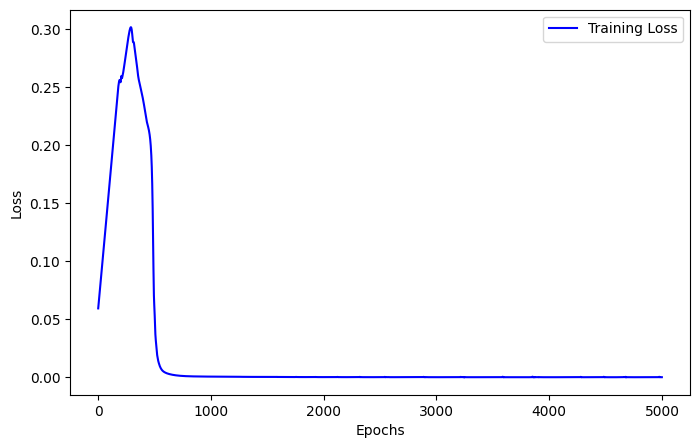


MSE (Test): 4.341329e-06
L2 Error (Test): 7.160130e-03


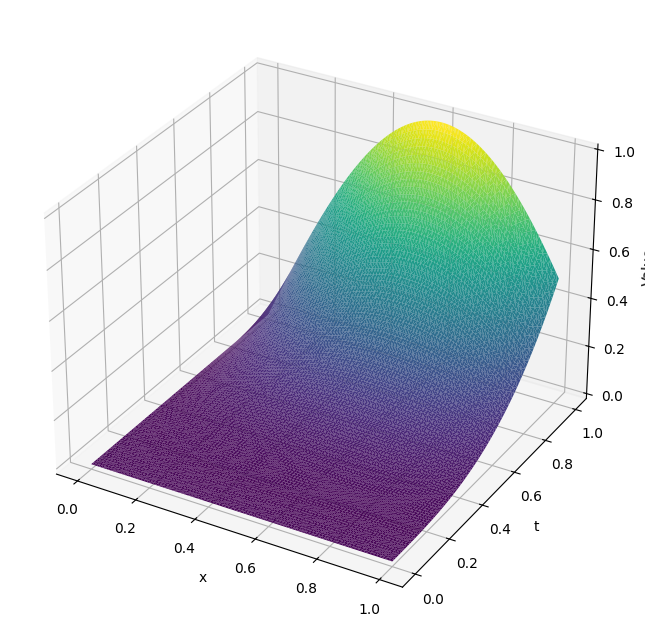

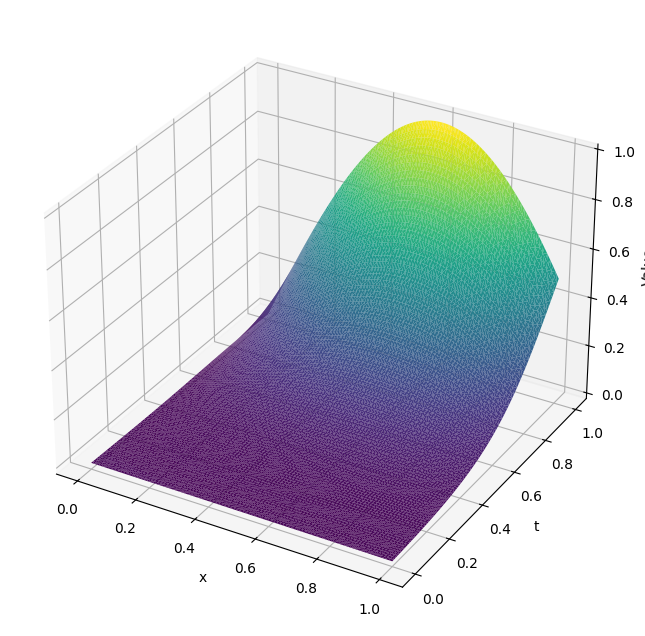

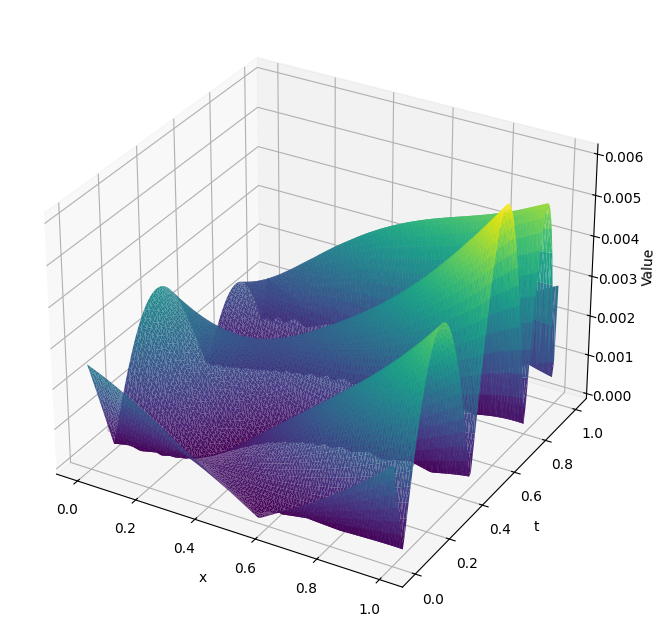

In [1]:
# using the hypertuned parameters from optuna
# xTanh activation function
# graph of loss, and analytical, predicted solution, error

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

class xTanh(nn.Module):
  def forward(self, x):
    return x*torch.tanh(x)

# Define the neural network
class NeuralNetwork(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(xTanh())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(xTanh())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Define the fractional derivative
def fractional_derivative(u_grid, t, alpha):
    dt = t[1] - t[0]
    eps = 1e-8  # Small value for numerical stability
    n_x, n_t = u_grid.shape
    frac_deriv = np.zeros_like(u_grid)

    l = [(k + 1)**(1 - alpha) - k**(1 - alpha) for k in range(n_t)]
    l = np.array(l, dtype=np.float32)

    for i in range(n_x):
        for j in range(1, n_t):
            term1 = l[0] * u_grid[i, j]
            term2 = np.sum([(l[j - k - 1] - l[j - k]) * u_grid[i, k] for k in range(1, j)])
            term3 = l[j - 1] * u_grid[i, 0]
            frac_deriv[i, j] = ((dt + eps)**(-alpha) / gamma(2 - alpha)) * (term1 - term2 - term3)

    return frac_deriv

# Unified function for Algorithm 1 with dynamic weighting
# alpha=0.3, num_epochs=5000, learning_rate=1e-4, hidden_dim=40, num_layers=6, n = 40 -> standard
def fPINN_solver(alpha=0.3, num_epochs=5000, learning_rate=1e-4, hidden_dim=40, num_layers=6, n = 40):
    # Define the mesh
    x = torch.linspace(0, 1, n, requires_grad=True).view(-1, 1)
    t = torch.linspace(0, 1, n, requires_grad=True).view(-1, 1)
    x, t = torch.meshgrid(x.squeeze(), t.squeeze(), indexing="ij")
    x, t = x.flatten().unsqueeze(-1), t.flatten().unsqueeze(-1)

    # Define the model
    model = NeuralNetwork(input_dim=2, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_values = []

    # Training loop
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        u_nn = model(torch.cat((x, t), dim=1))
        u_pred = u_nn

        # Convert predicted values to numpy for fractional derivative computation
        u_grid = u_pred.detach().numpy().reshape(n, n)  # Assuming a 40x40 grid
        frac_deriv = fractional_derivative(u_grid, t.detach().numpy().flatten(), alpha)

        # Convert fractional derivative back to tensor for loss calculation
        frac_deriv_tensor = torch.tensor(frac_deriv.flatten(), dtype=torch.float32, requires_grad=False, device=x.device)
        u_pred_x = torch.autograd.grad(u_pred, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]
        u_pred_xx = torch.autograd.grad(u_pred_x, x, grad_outputs=torch.ones_like(u_pred), create_graph=True)[0]

        # Source term f(x, t)
        f = (
        6 * torch.sin(5 * x* np.pi / 6 ) * ( (t**(3 - alpha)) / (gamma(4 - alpha)))
        + 0.01 * (t**6) * (5 * np.pi / 6) * torch.cos(5 * x * np.pi / 6) * torch.sin(5 * x* np.pi / 6 )
        + ((5 * np.pi / 6)**2) * (t**3) * torch.sin(5 * x * np.pi / 6 )
        - ((t**3) * torch.sin(5 * x*np.pi / 6 )) * (1 - (t**3) * torch.sin(5 *x *  np.pi / 6)) * ((t**3) * torch.sin(5 *x* np.pi / 6) - 0.5)
    )
        # Residual
        residual = frac_deriv_tensor  - u_pred_xx.flatten() + (0.01*u_pred*u_pred_x) - (u_pred.flatten() * (1 - u_pred.flatten()) * (u_pred.flatten() - 0.5)) - f.flatten()

        # Mean squared error
        mse = torch.mean(residual**2)

        # Boundary and initial conditions
        bc_left = model(torch.cat((torch.zeros_like(t), t), dim=1))
        bc_right = model(torch.cat((torch.ones_like(t), t), dim=1))
        ic = model(torch.cat((x, torch.zeros_like(x)), dim=1))

        bc_loss = torch.mean(bc_left**2 + (bc_right- (t**3)/2)**2)
        ic_loss = torch.mean(ic**2)

        # Dynamic weighting of the loss components
        weight_bc_ic = max(0.1, 1 - epoch / num_epochs)  # Start with 1 and decrease over time
        weight_residual = min(1, epoch / num_epochs)  # Start with 0 and increase over time

        # Total loss with dynamic weights
        total_loss = weight_residual * mse + weight_bc_ic * (bc_loss + ic_loss)
        total_loss.backward()
        optimizer.step()

        loss_values.append(total_loss.item())

        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item()}, BC Loss Weight: {weight_bc_ic}, Residual Weight: {weight_residual}")


    plt.figure(figsize=(8, 5))
    plt.plot(range(num_epochs), loss_values, label='Training Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("4.1loss_curve.png", dpi=600)
    plt.show()

    # Testing and visualization
    x_test = torch.linspace(0, 1, 100).view(-1, 1)
    t_test = torch.linspace(0, 1, 100).view(-1, 1)
    x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")
    x_test, t_test = x_test.flatten().unsqueeze(-1), t_test.flatten().unsqueeze(-1)

    model.eval()  # Set the model to evaluation mode
    u_pred = model(torch.cat((x_test, t_test), dim=1))
    u_exact = (t_test**3 )* torch.sin((5/6)* np.pi * x_test)
    error = torch.abs(u_pred - u_exact)

    # Calculate MSE and L2 error using trained weights
    mse_test = torch.mean((u_pred - u_exact)**2).item()
    l2_error = torch.norm(u_pred - u_exact).item() / torch.norm(u_exact).item()

    print(f"\nMSE (Test): {mse_test:.6e}")
    print(f"L2 Error (Test): {l2_error:.6e}")

    # Plot 3D results
    def plot_3d(x, t, values, title):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        x = x.cpu().numpy().flatten()
        t = t.cpu().numpy().flatten()
        values = values.detach().numpy().flatten()
        ax.plot_trisurf(x, t, values, cmap='viridis', edgecolor='none')
        # ax.set_title(title)
        ax.set_xlabel('x')
        ax.set_ylabel('t')
        ax.set_zlabel('Value')
        plt.savefig(f"{title}", dpi = 600)
        plt.show()

    plot_3d(x_test, t_test, u_exact, "Analytical Solution-1")
    plot_3d(x_test, t_test, u_pred, "Predicted Solution-1")
    plot_3d(x_test, t_test, error, "Error Distribution-1")

# Main
if __name__ == "__main__":
    fPINN_solver()
